** The Lending Club: Loan default prediction**

*MLND Capstone Project Notebook*

**II. Analysis **

*Data Exploration*

In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any abnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_



In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
import seaborn as sns
from sklearn import tree
%matplotlib inline

In [5]:
#df = pd.read_csv('loan.csv', na_values=['NA'], nrows=10000)
df = pd.read_csv('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/loan.csv', na_values=['NA'])

print (df.columns)
print (df.describe())
print (df['loan_status'].unique())

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
    

/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


                 id     member_id      loan_amnt    funded_amnt  \
count  8.873790e+05  8.873790e+05  887379.000000  887379.000000   
mean   3.246513e+07  3.500182e+07   14755.264605   14741.877625   
std    2.282734e+07  2.411335e+07    8435.455601    8429.897657   
min    5.473400e+04  7.047300e+04     500.000000     500.000000   
25%    9.206643e+06  1.087713e+07    8000.000000    8000.000000   
50%    3.443327e+07  3.709528e+07   13000.000000   13000.000000   
75%    5.490814e+07  5.847135e+07   20000.000000   20000.000000   
max    6.861706e+07  7.354484e+07   35000.000000   35000.000000   

       funded_amnt_inv       int_rate    installment    annual_inc  \
count    887379.000000  887379.000000  887379.000000  8.873750e+05   
mean      14702.464383      13.246740     436.717127  7.502759e+04   
std        8442.106732       4.381867     244.186593  6.469830e+04   
min           0.000000       5.320000      15.670000  0.000000e+00   
25%        8000.000000       9.990000     260.

How many null descriptions? 761350
Average length of Description Text 239.9646271889803


/Users/sergeboo/Software/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


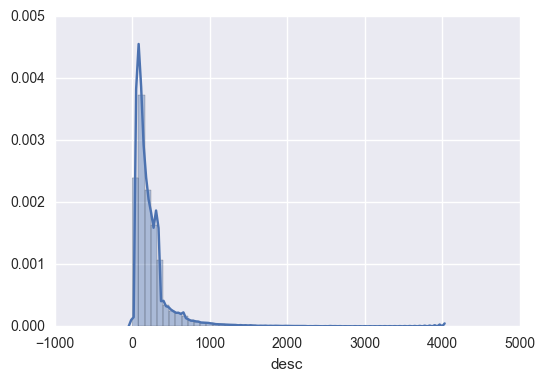

In [8]:
# How many null descriptions
print ("How many null descriptions? {}".format(len(df[df['desc'].isnull()])))

# Average length of non null descriptions
print ("Average length of Description Text {}".format(df['desc'].dropna().str.len().mean()))

sns.distplot(df['desc'].dropna().str.len())

In [6]:
data_dictionary = pd.read_excel('/Users/sergeboo/Projects/machine-learning/kaggle/lending-club/LCDataDictionary.xlsx')

print(data_dictionary.shape[0])
print(data_dictionary.columns.tolist())

data_dictionary.rename(columns={'LoanStatNew': 'name',
                                'Description': 'description'})
data_dictionary.head(10)

80
['LoanStatNew', 'Description']


,LoanStatNew,Description
0,addr_state,The state provided by the borrower in the loan...
1,annual_inc,The self-reported annual income provided by th...
2,annual_inc_joint,The combined self-reported annual income provi...
3,application_type,Indicates whether the loan is an individual ap...
4,collection_recovery_fee,post charge off collection fee
5,collections_12_mths_ex_med,Number of collections in 12 months excluding m...
6,delinq_2yrs,The number of 30+ days past-due incidences of ...
7,desc,Loan description provided by the borrower
8,dti,A ratio calculated using the borrower’s total ...
9,dti_joint,A ratio calculated using the co-borrowers' tot...


In [ ]:
categorical_cols = ['grade', 'sub_grade', 'purpose', 'loan_status', 'home_ownership', 'emp_length', 'application_type']
id_cols = ['id', 'member_id', '']
time_cols = ['term', 'mths_since_last_record', 'issue_d', 'last_pymnt_d', 'next_pymnt_d']
status_cols = ['loan_status', 'verification_status', 'initial_list_status']
location_cols = ['zip_code', 'addr_state']
numerical_cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', \
                  'total_pymnt', 'annual_inc', 'installment', 'open_acc', 'dti', 'emp_length' , 'out_prncp']
desc_cols = ['url', 'desc', 'title']

print(df[categorical_cols].head(30))
print(df[time_cols].head(30))
print(df[numerical_cols].head(30))
print(df[location_cols].head(30))
print(df[time_cols].head(30))
print(df[desc_cols].head(30))

In [11]:
# Code here
half_count = len(df) / 2
df_loans = df.dropna(thresh=half_count, axis=1) # Drop any column with more than 50% missing values
df_loans = df_loans.drop(['url','title'], axis=1)      # These columns are not useful for our purpose
df_loans.info()

status_meaning = [
    "Loan is up to date on all outstanding payments.",
    "Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.",
    "Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached.",
    "Loan has not been current for 31 to 120 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.",
    "New loan that has passed all Lending Club reviews, received full funding, and has been issued.",
    "Loan is past due but within the 15-day grace period.",
    'Loan has not been current for 16 to 30 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.',
    "Does not meet the credit policy. Status:Fully ...",
    "Loan has not been current for 121 days or more. Learn more about the difference between “default” and “charge off”.",
    "Does not meet the credit policy. Status:Charge..."]

status, count = df_loans["loan_status"].value_counts().index, df_loans["loan_status"].value_counts().values

loan_statuses_explanation = pd.DataFrame({'Loan Status': status, 'Count': count, 'Meaning': status_meaning})[['Loan Status', 'Count', 'Meaning']]

pd.set_option('display.max_colwidth', 255)

loan_statuses_explanation

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 51 columns):
id                            887379 non-null int64
member_id                     887379 non-null int64
loan_amnt                     887379 non-null float64
funded_amnt                   887379 non-null float64
funded_amnt_inv               887379 non-null float64
term                          887379 non-null object
int_rate                      887379 non-null float64
installment                   887379 non-null float64
grade                         887379 non-null object
sub_grade                     887379 non-null object
emp_title                     835922 non-null object
emp_length                    887379 non-null object
home_ownership                887379 non-null object
annual_inc                    887375 non-null float64
verification_status           887379 non-null object
issue_d                       887379 non-null object
loan_status                   887379 

,Loan Status,Count,Meaning
0,Current,601779,Loan is up to date on all outstanding payments.
1,Fully Paid,207723,"Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment."
2,Charged Off,45248,"Loan for which there is no longer a reasonable expectation of further payments. Generally, Charge Off occurs no later than 30 days after the Default status is reached."
3,Late (31-120 days),11591,Loan has not been current for 31 to 120 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
4,Issued,8460,"New loan that has passed all Lending Club reviews, received full funding, and has been issued."
5,In Grace Period,6253,Loan is past due but within the 15-day grace period.
6,Late (16-30 days),2357,Loan has not been current for 16 to 30 days. Learn more about the tools Lending Club has to deal with delinquent borrowers.
7,Does not meet the credit policy. Status:Fully Paid,1988,Does not meet the credit policy. Status:Fully ...
8,Default,1219,Loan has not been current for 121 days or more. Learn more about the difference between “default” and “charge off”.
9,Does not meet the credit policy. Status:Charged Off,761,Does not meet the credit policy. Status:Charge...


*Exploratory Visualization*

In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_



In [ ]:
sns.pairplot(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'total_pymnt', \
                  'dti', 'loan_status']].dropna(), hue='loan_status')

In [ ]:
plt.xticks(rotation=90)
plt.xlabel('Loan Status')

df_status = df.loc[df['loan_status'].isin(['Current','Charged Off','Default','Fully Paid','In Grace Period','Late (16-30 days)','Late (31-120 days)'])]

sns.countplot(df_status['loan_status'], palette='Set2')

In [ ]:
df['loan_status'].value_counts()

In [ ]:
sns.distplot(df['loan_amnt'])

In [ ]:
sns.stripplot(data=df[['loan_status','int_rate', 'purpose']], x='loan_status', y='int_rate', jitter=True, hue='purpose')

In [ ]:
plt.xticks(rotation=90)
sns.violinplot(data=df[['loan_status','int_rate', 'purpose']], x='loan_status', y='int_rate')

*Algorithms and Techniques*

In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_



*Benchmark*

In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_


**III. Methodology**

*Data Preprocessing*

In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


*Implementation*

In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_



*Refinement*

In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_



** IV. Results **

*Model Evaluation and Validation*

In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_


*Justification*

In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_